# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# SK
# Kmeans & PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules.get_data import get_data

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Constantes

In [3]:
CLUSTER_COL = 'cluster'
FIGSIZE = (10, 6)
FIG_SQUARE = (10,10)

## Importacion datos

### CSVs

In [4]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_s = get_data('daily_sales_with_events.csv')

In [5]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_s.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [6]:
# Añadimos Christmas a calendario
# Asegurarnos de que la columna 'fecha' sea del tipo datetime
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'], errors='coerce')  # Coerce convierte a NaT si hay errores

# Extraer los años de las fechas existentes
years = df_cal['fecha'].dt.year.unique()

# Crear un DataFrame para el evento "Christmas"
christmas_data = {
    'fecha': [f'{year}-12-25' for year in years],
    'event': ['Christmas'] * len(years)
}

df_christmas = pd.DataFrame(christmas_data)

# Asegurarnos de que 'fecha' en df_christmas también sea datetime
df_christmas['fecha'] = pd.to_datetime(df_christmas['fecha'])

# Combinar el DataFrame original con el nuevo DataFrame
df_cal = pd.concat([df_cal, df_christmas], ignore_index=True)

# Ordenar el DataFrame por fecha
df_cal = df_cal.sort_values(by='fecha').reset_index(drop=True)

# Borramos el ultimo registro ya que no tenemos datos de las Navidades de 2016
df_cal = df_cal.drop(df_cal.index[-1])

# Rehacemos columna event
# 1. Eliminar la columna event de df_s
df_s.drop(columns=['event'], inplace=True)

# 2. Crear un diccionario a partir de df_cal para mapear fechas a eventos
event_map = pd.Series(df_cal.event.values, index=df_cal.fecha).to_dict()

# 3. Usar map para añadir la columna event a df_s
df_s['event'] = df_s['date'].map(event_map)

df_s.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [7]:
# Seleccionamos de una semana antes a una despues de fin de año
# Convertir la columna 'date' a datetime si no lo está
df_s['date'] = pd.to_datetime(df_s['date'])

# Definir el rango de fechas desde 7 días antes del 1 de enero de 2014 hasta 7 días después del 1 de enero de 2016
start_date = '2013-12-25'  # 7 días antes del 1 de enero de 2014
end_date = '2016-01-07'    # 7 días después del 1 de enero de 2016

# Filtrar el DataFrame dentro del rango de fechas
df_s = df_s[(df_s['date'] >= start_date) & (df_s['date'] <= end_date)]

# Cambiamos NaN de event por None
df_s['event'] = df_s['event'].fillna('None')

In [8]:
df_s.shape

(8356979, 12)

In [9]:
df_s.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8801219,SUPERMARKET_3_586,NYC_2,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,Christmas
8801220,SUPERMARKET_3_756,NYC_2,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,Christmas
8801221,SUPERMARKET_3_565,NYC_3,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,Christmas
8801222,SUPERMARKET_3_756,NYC_3,2013-12-25,2,2013,52,2.976,5.952,12,Wednesday,2,Christmas
8801223,SUPERMARKET_3_555,BOS_1,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,Christmas


# SEGMENTACION

## Data (copy)

In [10]:
items = df_items.copy()
shops = df_shops.copy()
df_events = df_s.copy()

display(df_events.shape)

(8356979, 12)

## Functions

In [11]:
# CONSTANTES
FIGSIZE = (12, 6)
CLUSTER_COL = 'cluster'
# obtenemos EVENTS de todos los valores unicos de la columna event de df_cal
EVENTS = df_cal['event'].unique().tolist()
display(EVENTS)
SCALER = RobustScaler

['SuperBowl',
 'Ramadan starts',
 'Thanksgiving',
 'Christmas',
 'NewYear',
 'Easter']

In [12]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

In [13]:
def features_creation(data):
    # Ordenar el DataFrame por 'store_code' y 'date' para asegurar un cálculo correcto
    data = data.sort_values(['store_code', 'date'])

    # Filtrar los eventos válidos (excluir NaN y 'None')
    valid_events = data[~data['event'].isin([None, 'None'])]['event'].unique()

    # Inicializar un DataFrame con solo la columna 'store_code' para almacenar todas las características
    event_features = pd.DataFrame(data['store_code'].unique(), columns=['store_code'])

    # Calcular la media solo para los 7 días antes y después de cada evento
    for event in valid_events:
        # Filtrar datos por el evento actual
        event_data = data[data['event'] == event]

        # Calcular medias para los días del evento
        event_means = event_data.groupby('store_code').agg({
            'total_sales': 'mean',
            'units': 'mean',
            'sell_price': 'mean'
        }).rename(columns={
            'total_sales': f'{event}_mean_total_sales',
            'units': f'{event}_mean_units',
            'sell_price': f'{event}_mean_sell_price'
        }).reset_index()

        # Filtrar datos para los 7 días antes del evento
        prev_7_days = data[data['date'].isin(event_data['date'] - pd.Timedelta(days=7))]

        # Calcular medias para los 7 días antes
        prev_7_means = prev_7_days.groupby('store_code').agg({
            'total_sales': 'mean',
            'units': 'mean',
            'sell_price': 'mean'
        }).rename(columns={
            'total_sales': f'{event}_prev_7_mean_total_sales',
            'units': f'{event}_prev_7_mean_units',
            'sell_price': f'{event}_prev_7_mean_sell_price'
        }).reset_index()

        # Filtrar datos para los 7 días después del evento
        next_7_days = data[data['date'].isin(event_data['date'] + pd.Timedelta(days=7))]

        # Calcular medias para los 7 días después
        next_7_means = next_7_days.groupby('store_code').agg({
            'total_sales': 'mean',
            'units': 'mean',
            'sell_price': 'mean'
        }).rename(columns={
            'total_sales': f'{event}_next_7_mean_total_sales',
            'units': f'{event}_next_7_mean_units',
            'sell_price': f'{event}_next_7_mean_sell_price'
        }).reset_index()

        # Merge all event means into a single DataFrame
        event_data_merged = event_means.merge(prev_7_means, on='store_code').merge(next_7_means, on='store_code')

        # Merge the new event data into the main event_features DataFrame
        event_features = event_features.merge(event_data_merged, on='store_code', how='left')

    # Seleccionar solo las características creadas para los eventos
    features = list(event_features.columns)

    return event_features, features


In [14]:
# Limpieza de features
def clean_features(data, corr_threshold=0.9):
    """
    Limpia las características del DataFrame eliminando las columnas numéricas altamente correlacionadas

    Parameters:
    data (pd.DataFrame): El DataFrame que contiene las características.
    corr_threshold (float): El umbral de correlación para eliminar columnas altamente correlacionadas.

    Returns:
    columnas a eliminar
    """

    # 1. Eliminar columnas altamente correlacionadas
    print(f"Eliminando columnas altamente correlacionadas (umbral={corr_threshold})...")
    numeric_cols = data.select_dtypes(include=np.number)
    corr_matrix = numeric_cols.corr().abs()

    # Crea un set para almacenar columnas que serán eliminadas
    drop_cols = set()

    # Iterar sobre la matriz de correlación superior (triangular)
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > corr_threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]

                # Decidir qué columna eliminar (nos quedamos con la de mayor varianza)
                var_i = data[colname_i].var()
                var_j = data[colname_j].var()

                if var_i > var_j:
                    drop_cols.add(colname_j)
                else:
                    drop_cols.add(colname_i)

    # Mostrar resumen de lo eliminado
    print(f"Columnas a eliminar: {list(drop_cols)}")

    return drop_cols


In [15]:
# 1. Preparación de datos
def prepare_data(data):
    data['date'] = pd.to_datetime(data['date'])
    # Renombramos raw_earn a total_sales
    data.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return data

# 3. Segmentación de productos usando K-means con RobustScaler
# 3.1 - Grafico silueta
def plot_silhouette(data_scaled, ran=20, event=None):

  silhouette_scores = []

  for k in range(2, ran):
      kmeans = init_kmeans(k)
      kmeans.fit(data_scaled)
      silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

  title = "Silhouette score"
  if event:
    title += f" para el evento {event}"

  fig = px.line(
      x=range(2, ran),
      y=silhouette_scores,
      title=title,
      labels={"x": "k", "y": "Silhouette score"},
  )
  fig.show()

# 3.2 - Segementacion con optimal_k
def segment_products_kmeans(data_dict, n_clusters=3):

    # FEATURE TOOLS -> helper
    X = data_dict['df_features']
    features = data_dict['features']
    X_scaled = data_dict['X_scaled']
    scaler = data_dict['scaler']
    # END FEATURE TOOLS

    # Aplica Kmeans sobre DF scalado -> helper
    kmeans = init_kmeans(n_clusters)

    X[CLUSTER_COL] = kmeans.fit_predict(X_scaled)

    # Calcula Silueta
    silhouette_avg = silhouette_score(X_scaled, X[CLUSTER_COL])
    print(f"El score de silueta promedio es: {silhouette_avg}")

    # Obtiene centroides y los devuelve en un DF
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids, columns=features)
    centroid_df[CLUSTER_COL] = range(n_clusters)

    return X, centroid_df

In [16]:
# Visualizacion con reduccion de dimensionalidad
def pca_and_plot_clusters(data, n_clusters, detail=None):
    """
    Realiza reducción de dimensionalidad con PCA a 2 componentes principales,
    muestra la varianza acumulada y dibuja un scatter plot de los clusters.

    Parámetros:
    - data: DataFrame con las características (sin la columna de clusters).
    - n_clusters: Número de clusters para KMeans.
    """
    # Rellenamos si hay nan con 0 en data
    if data.isna().any().any():
      data = data.fillna(0)
    # Preprocesar las características (escalado)
    X_scaled, scaler = preprocess_features(data, Scaler=RobustScaler)

    # Aplicar PCA para reducir a 2 dimensiones
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Mostrar la varianza explicada acumulada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    print(f"Varianza explicada por cada componente principal: {explained_variance}")
    print(f"Varianza acumulada: {cumulative_variance}")

    # Aplicar KMeans en las 2 dimensiones obtenidas por PCA
    kmeans = init_kmeans(n_clusters)
    clusters = kmeans.fit_predict(X_pca)

    # Crear DataFrame para visualización
    pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters

    # Obtener los centroides del KMeans en las dimensiones reducidas por PCA
    centroids = kmeans.cluster_centers_

    # Plotear los clusters en un scatter plot
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='bright', s=100, alpha=0.7)

    # Añadir los centroides al scatter plot
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroides')

    # Añadir leyenda y título
    plt.legend()
    title = f'Clusters visualizados en 2D con PCA'
    if detail:
      title += f' : {detail}'
    plt.title(title)
    plt.show()

    return pca_df, centroids

## Clustering

In [17]:
# Preparamos df original
df = prepare_data(df_events) # total_sales = raw_earn

In [18]:
# Creacion caracteristicas para segmentacion de TODOS los eventos
df_features, features = features_creation(df)

In [19]:
df_features['store_code'].nunique()

10

In [20]:
# Guardamos lista de eventos unicos para loopear
events_list = df['event'].unique().tolist()

# Quitamos None
events_list.remove('None')

In [21]:
# Inicializamos df_shops_with_clusters
df_shops_with_clusters = shops[['store_code']].copy()

In [22]:
df_shops_with_clusters.shape

(10, 1)

Evento: Christmas
Eliminando columnas altamente correlacionadas (umbral=0.9)...
Columnas a eliminar: ['Christmas_prev_7_mean_total_sales', 'Christmas_prev_7_mean_units', 'Christmas_prev_7_mean_sell_price']


El score de silueta promedio es: 0.41168695170108077


,0,1
Christmas_next_7_mean_sell_price,4.672352,4.880269
Christmas_mean_total_sales,2.006833,3.669333
Christmas_next_7_mean_units,2.805205,3.224107
Christmas_next_7_mean_total_sales,10.257210,12.231035
Christmas_mean_units,1.022222,1.503704
Christmas_mean_sell_price,1.962033,2.532267
cluster,0.000000,1.000000


Varianza explicada por cada componente principal: [0.53367556 0.3347193 ]
Varianza acumulada: [0.53367556 0.86839486]


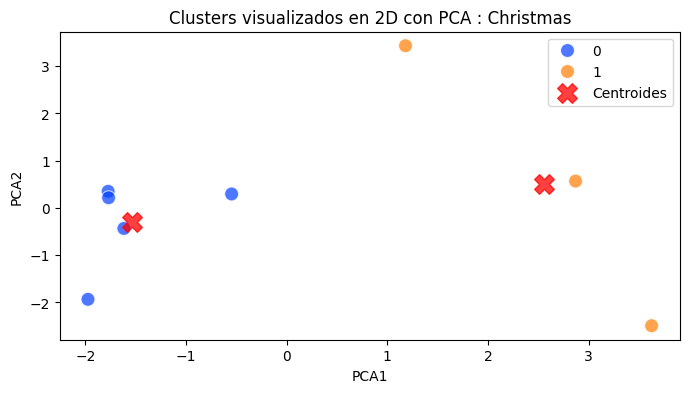


Christmas DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Evento: NewYear
Eliminando columnas altamente correlacionadas (umbral=0.9)...
Columnas a eliminar: ['NewYear_mean_units', 'NewYear_mean_sell_price', 'NewYear_next_7_mean_units']


El score de silueta promedio es: 0.36701804950363615


,0,1
NewYear_mean_total_sales,10.257210,12.231035
NewYear_next_7_mean_total_sales,11.086882,12.669394
NewYear_prev_7_mean_units,1.022222,1.503704
NewYear_next_7_mean_sell_price,4.596629,4.814762
NewYear_prev_7_mean_sell_price,1.962033,2.532267
NewYear_prev_7_mean_total_sales,2.006833,3.669333
cluster,0.000000,1.000000


Varianza explicada por cada componente principal: [0.48406734 0.31294829]
Varianza acumulada: [0.48406734 0.79701563]


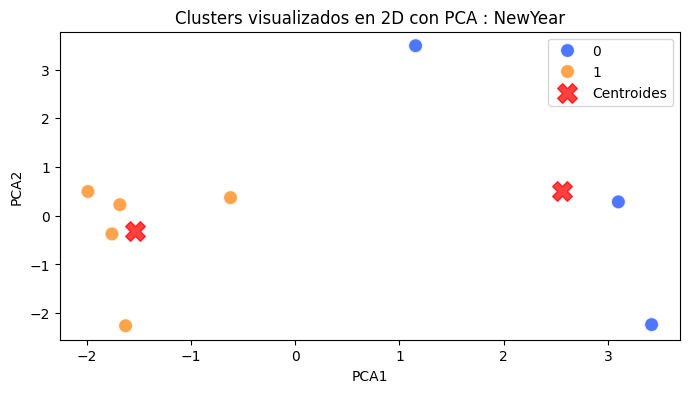


NewYear DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Evento: SuperBowl
Eliminando columnas altamente correlacionadas (umbral=0.9)...
Columnas a eliminar: ['SuperBowl_next_7_mean_total_sales', 'SuperBowl_next_7_mean_sell_price', 'SuperBowl_prev_7_mean_units', 'SuperBowl_mean_units', 'SuperBowl_prev_7_mean_total_sales', 'SuperBowl_prev_7_mean_sell_price', 'SuperBowl_next_7_mean_units']


El score de silueta promedio es: 0.6277119883902166


,0,1
SuperBowl_mean_sell_price,4.655135,4.907752
SuperBowl_mean_total_sales,12.134118,18.383544
cluster,0.000000,1.000000


Varianza explicada por cada componente principal: [0.94727272 0.05272728]
Varianza acumulada: [0.94727272 1.        ]


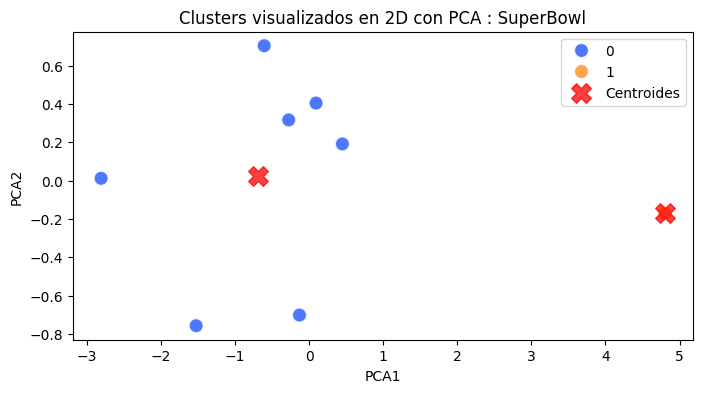


SuperBowl DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Evento: Easter
Eliminando columnas altamente correlacionadas (umbral=0.9)...
Columnas a eliminar: ['Easter_next_7_mean_sell_price', 'Easter_mean_units', 'Easter_next_7_mean_total_sales', 'Easter_prev_7_mean_units', 'Easter_next_7_mean_units', 'Easter_prev_7_mean_total_sales']


El score de silueta promedio es: 0.5576062997928162


,0,1,2
Easter_mean_total_sales,19.262468,13.379365,10.656011
Easter_prev_7_mean_sell_price,4.991456,5.011331,4.670273
Easter_mean_sell_price,5.118076,4.993430,4.604509
cluster,0.000000,1.000000,2.000000


Varianza explicada por cada componente principal: [0.78673661 0.20170627]
Varianza acumulada: [0.78673661 0.98844288]


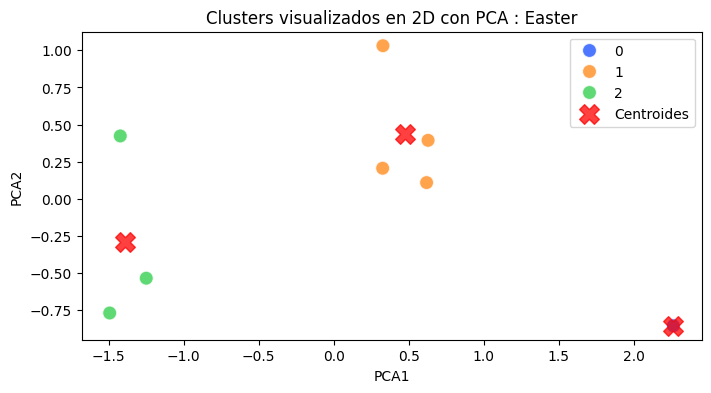


Easter DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Evento: Ramadan starts
Eliminando columnas altamente correlacionadas (umbral=0.9)...
Columnas a eliminar: ['Ramadan starts_prev_7_mean_sell_price', 'Ramadan starts_mean_total_sales', 'Ramadan starts_mean_sell_price', 'Ramadan starts_next_7_mean_units', 'Ramadan starts_prev_7_mean_total_sales', 'Ramadan starts_mean_units', 'Ramadan starts_prev_7_mean_units']


El score de silueta promedio es: 0.5735544240922804


,0,1
Ramadan starts_next_7_mean_total_sales,11.238091,17.142394
Ramadan starts_next_7_mean_sell_price,4.676735,5.079173
cluster,0.000000,1.000000


Varianza explicada por cada componente principal: [0.87914838 0.12085162]
Varianza acumulada: [0.87914838 1.        ]


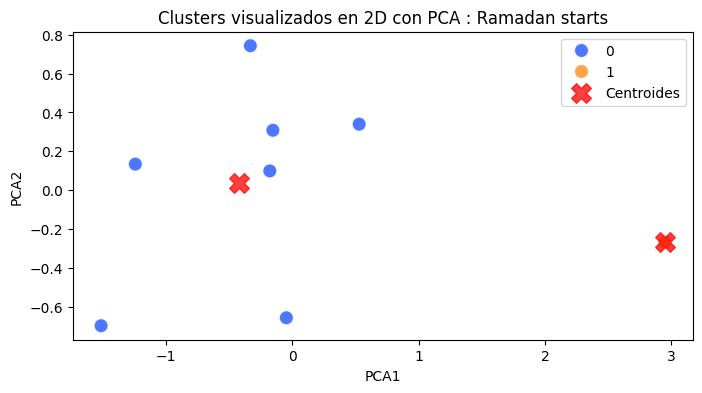


Ramadan starts DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Evento: Thanksgiving
Eliminando columnas altamente correlacionadas (umbral=0.9)...
Columnas a eliminar: ['Thanksgiving_next_7_mean_units', 'Thanksgiving_prev_7_mean_units', 'Thanksgiving_mean_units']


El score de silueta promedio es: 0.3207579083774127


,0,1
Thanksgiving_next_7_mean_total_sales,10.962958,15.269079
Thanksgiving_prev_7_mean_sell_price,4.850889,4.794420
Thanksgiving_mean_total_sales,11.164082,11.203174
Thanksgiving_prev_7_mean_total_sales,10.391705,12.529409
Thanksgiving_next_7_mean_sell_price,4.829390,4.810930
Thanksgiving_mean_sell_price,4.809687,4.665285
cluster,0.000000,1.000000


Varianza explicada por cada componente principal: [0.50068298 0.36405021]
Varianza acumulada: [0.50068298 0.86473319]


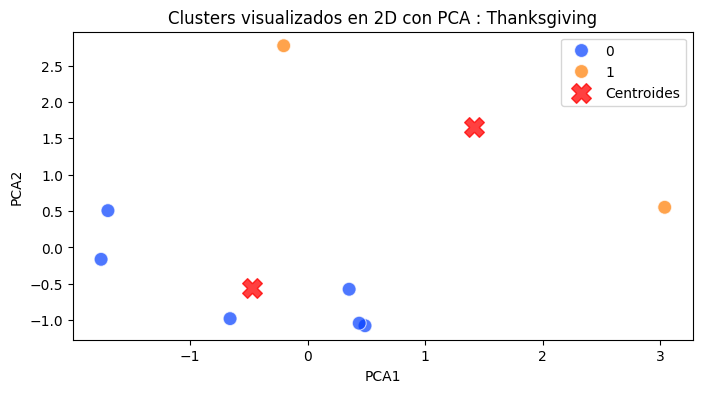


Thanksgiving DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::



In [23]:
for event in events_list:
  print(f'Evento: {event}')

  # Seleccionamos caracteristicas no relativas al evento
  selected_features = [feature for feature in features if feature.startswith(event)]

  # Quitamos NaN
  df_features.dropna(subset=selected_features, inplace=True)

  # Limpiamos features high correlated
  cols_to_drop = clean_features(df_features[selected_features], corr_threshold=0.9)

  # Actualizamos selected_features
  selected_features = list(set(selected_features) - set(cols_to_drop))

  # Preprocesamiento
  scaled_df, scaler = preprocess_features(df_features[selected_features], Scaler=SCALER)

  # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

  # Silhouette
  length = scaled_df.shape[0] # Por si son menos tiendas del total (alguna no tiene ventas en el evento)
  plot_silhouette(scaled_df, ran=length, event=event)

  # Segmentacion con optimal_k
  if event == 'Easter':
    optimal_k = 3 # Segun grafico de silueta
  else:
    optimal_k = 2 # Segun grafico de silueta

  data = {
      'df_features': df_features,
      'features': selected_features,
      'X_scaled': scaled_df,
      'scaler': scaler
  }

  product_segments, centroid_df = segment_products_kmeans(data, n_clusters=optimal_k)

  # Renombramos CLUSTER_COL de product_segmentes a {event}
  product_segments = product_segments.rename(columns={CLUSTER_COL: f'{event}'})

  # Añadimos columna cluster a df_shops_with_clusters desde product_segments usando columna 'store_code'
  df_shops_with_clusters = df_shops_with_clusters.merge(product_segments[['store_code', event]], on='store_code', how='left')

  display(centroid_df.T)
  pca_df, pca_centroids = pca_and_plot_clusters(data['df_features'][selected_features], n_clusters=optimal_k, detail=event)

  print(f'\n{event} DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::\n')

In [24]:
# Rellenamos NaN con -1
df_shops_with_clusters = df_shops_with_clusters.fillna(-1)

# Vemos shops que tengan al menos una columna numerica igual o mayor que cero
shops_filtered_by_events_influence = df_shops_with_clusters[df_shops_with_clusters.iloc[:, 1:].ge(0).any(axis=1)]

# Convertimos todas las numericas en int
shops_filtered_by_events_influence[shops_filtered_by_events_influence.select_dtypes(include='number').columns] = shops_filtered_by_events_influence.select_dtypes(include='number').astype(int)

display(shops_filtered_by_events_influence.shape)

shops_filtered_by_events_influence.head(10)

(8, 7)

,store_code,Christmas,NewYear,SuperBowl,Easter,Ramadan starts,Thanksgiving
1,NYC_2,0,0,0,1,0,0
2,NYC_3,1,1,1,0,1,1
4,BOS_1,0,0,0,1,0,0
5,BOS_2,1,1,0,1,0,0
6,BOS_3,1,1,0,1,0,0
7,PHI_1,0,0,0,2,0,0
8,PHI_2,0,0,0,2,0,1
9,PHI_3,0,0,0,2,0,0


# Informes adicionales

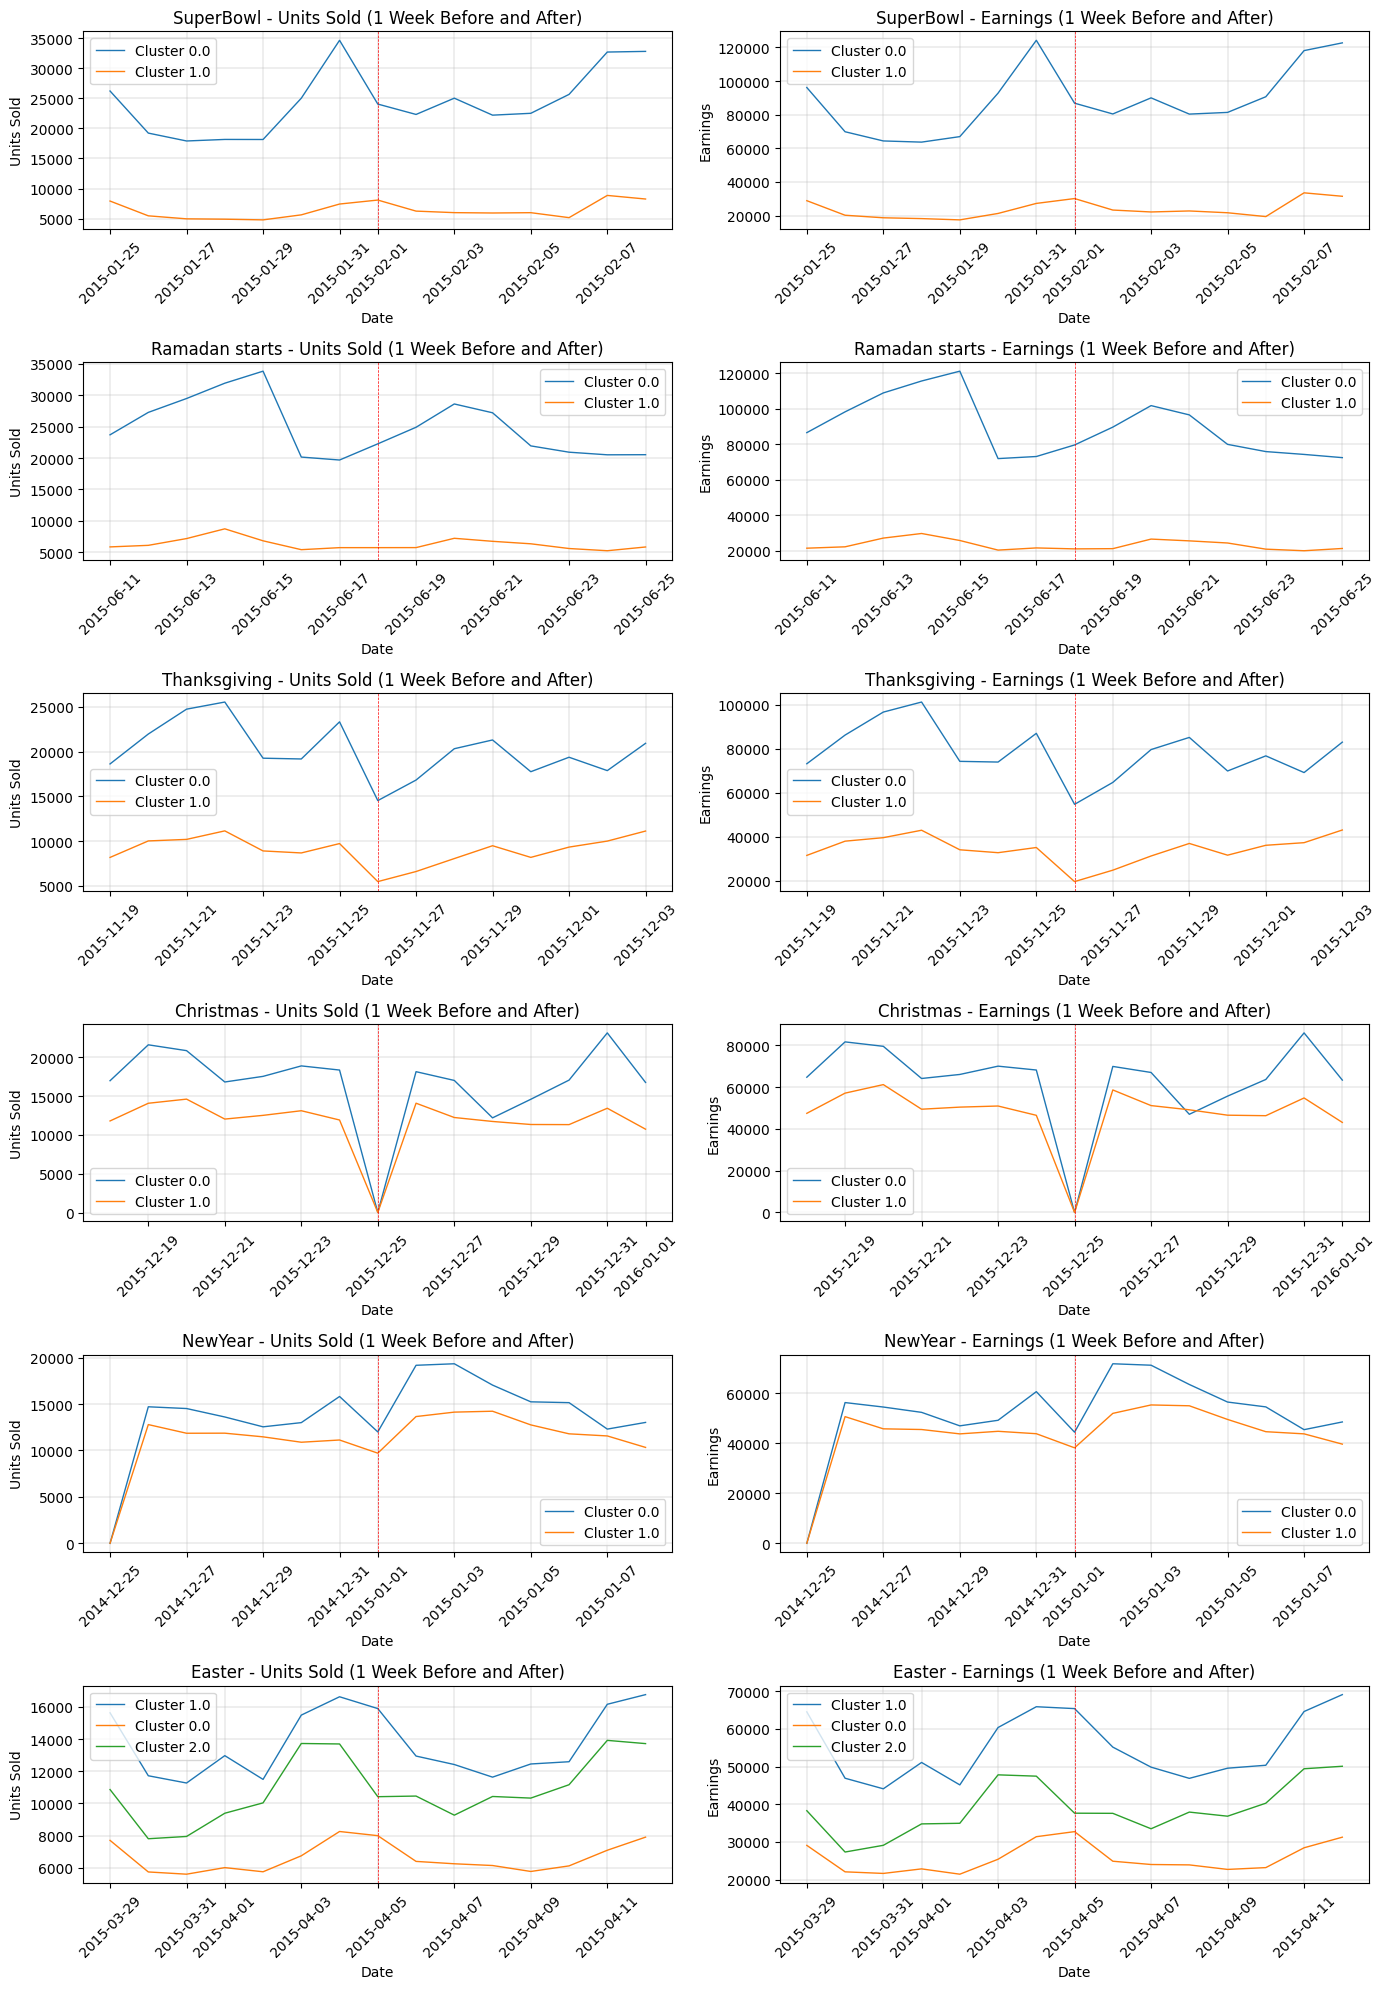

In [25]:
import datetime as dt

df_events = shops_filtered_by_events_influence.copy()

# Convertir la columna 'date' de df_s a datetime
df_s['date'] = pd.to_datetime(df_s['date'])

# Unir los dos dataframes por la columna 'shop'
df_merged = pd.merge(df_s, df_events, on='store_code', how='left')

# Lista de eventos y ventana de tiempo alrededor del evento (una semana antes y después)
event_columns = EVENTS

df_2015 = df_s[df_s['year'] == 2015]
event_dates = {
    'NewYear': df_2015[df_2015['event'] == 'NewYear']['date'].min(),
    'Christmas': df_2015[df_2015['event'] == 'Christmas']['date'].min(),
    'SuperBowl': df_2015[df_2015['event'] == 'SuperBowl']['date'].min(),
    'Easter': df_2015[df_2015['event'] == 'Easter']['date'].min(),
    'Ramadan starts': df_2015[df_2015['event'] == 'Ramadan starts']['date'].min(),
    'Thanksgiving': df_2015[df_2015['event'] == 'Thanksgiving']['date'].min()
}

# Función para filtrar una semana antes y después del evento
def filter_by_event_window(df, event_date):
    start_date = event_date - pd.DateOffset(days=7)
    end_date = event_date + pd.DateOffset(days=7)
    return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Graficar la evolución de ingresos y unidades por cluster (evento)
fig, ax = plt.subplots(len(event_columns), 2, figsize=(14, 20))

for i, event in enumerate(event_columns):
    # Filtrar los productos que tienen información en el evento (columna)
    df_event = df_merged[df_merged[event].notna()]

    # Filtrar las fechas de una semana antes y después del evento
    df_event_window = filter_by_event_window(df_event, event_dates[event])

    # Agrupar por los distintos valores (clusters) de ese evento
    for cluster_value in df_event_window[event].unique():
        df_cluster = df_event_window[df_event_window[event] == cluster_value]

        # Agrupar por fecha para calcular el total de unidades e ingresos por día
        df_cluster_grouped = df_cluster.groupby('date').agg({'units': 'sum', 'raw_earn': 'sum'}).reset_index()

        # Graficar las unidades vendidas (línea fina)
        ax[i, 0].plot(df_cluster_grouped['date'], df_cluster_grouped['units'], label=f'Cluster {cluster_value}', linewidth=1)
        ax[i, 0].set_title(f'{event} - Units Sold (1 Week Before and After)')
        ax[i, 0].set_xlabel('Date')
        ax[i, 0].set_ylabel('Units Sold')

        # Graficar los ingresos (línea fina)
        ax[i, 1].plot(df_cluster_grouped['date'], df_cluster_grouped['raw_earn'], label=f'Cluster {cluster_value}', linewidth=1)
        ax[i, 1].set_title(f'{event} - Earnings (1 Week Before and After)')
        ax[i, 1].set_xlabel('Date')
        ax[i, 1].set_ylabel('Earnings')

    # Añadir la línea vertical discontinua en la fecha del evento
    ax[i, 0].axvline(x=event_dates[event], color='red', linestyle='--', linewidth=0.5)
    ax[i, 1].axvline(x=event_dates[event], color='red', linestyle='--', linewidth=0.5)

    # Rotar las etiquetas de las fechas en el eje X
    ax[i, 0].tick_params(axis='x', rotation=45)
    ax[i, 1].tick_params(axis='x', rotation=45)

    # Añadir leyenda para cada gráfico
    ax[i, 0].legend()
    ax[i, 1].legend()
    # Añadir grid
    ax[i, 0].grid(linewidth=0.3)
    ax[i, 1].grid(linewidth=0.3)

plt.tight_layout()
plt.show()


# CLUSTER DICT : PENDING





# Guardamos CSV

In [26]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_with_events_influence.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# df_shops_with_clusters.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>